# Installing MediaPipe

In [1]:
%%capture
!pip install mediapipe

# Importing Libraries

In [2]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from google.colab.patches import cv2_imshow

# Loading Data

In [3]:
# link of the data
# http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/Database/AFLW2000-3D.zip

# Loading AFLW2000 Data
%%capture
if os.path.isfile('/content/AFLW2000-3D.zip') == False:
  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
  !unzip /content/AFLW2000-3D.zip

#  Preparing Data 










In [7]:
file_names = sorted([Path(f).stem for f in glob.glob("/content/AFLW2000/*.mat")])
faceModule = mediapipe.solutions.face_mesh

detected_files = []
X_points = []
Y_points = []
labels = []

# loading image and its correspinding mat file
for filename in file_names:
  with faceModule.FaceMesh(static_image_mode=True) as faces:
    image = cv2.imread('/content/AFLW2000/'+filename+'.jpg')
    # processing the face to extract the landmark points (468 point) for each x,y,z
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None: 
          # appending the file names where have been detected.
          detected_files.append(filename)
          # detecting the face
          face = results.multi_face_landmarks[0]
          # initializing two lists to store the points for the image.
          X = []
          Y = []
          # looping over the faces in the image
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image.
              shape = image.shape 
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              X.append(relative_x)
              Y.append(relative_y)
          # converting the lists to numpy arrays
          X = np.array(X)
          Y = np.array(Y)
          # appending the points of the images in the list of all image overall
          X_points.append(X)
          Y_points.append(Y)

          # loading the mat file to extract the labels (pitch,yaw,roll)
          mat_file = sio.loadmat('/content/AFLW2000/'+filename+'.mat')
          # extracting the labels 3 angels
          pose_para = mat_file["Pose_Para"][0][:3]
          # appending the 3 angels to labels list
          labels.append(pose_para)

X_points = np.array(X_points)
Y_points = np.array(Y_points)
labels = np.array(labels)

pitch_label = labels[:,0] 
yaw_label = labels[:,1]   
roll_label = labels[:,2]   

#  Centering and Normalizing 











In [8]:
#centering data
C_X = X_points - X_points[:,98].reshape(-1,1) 
C_Y = Y_points - Y_points[:,98].reshape(-1,1)

# normalizing the data 
Y_171 = Y_points[:,171]
Y_10 = Y_points[:,10]
X_171 = X_points[:,171]
X_10 = X_points[:,10]

#  distance
d = np.linalg.norm(np.array((X_10,Y_10)) - np.array((X_171,Y_171)),axis = 0).reshape(-1,1)
norm_X = C_X / d
norm_Y = C_Y /d 
#features shape ( )
features = np.hstack([norm_X,norm_Y])
print(features.shape)

(1853, 936)


# Splitting Data






In [11]:
X_train,X_val,y_train,y_val= train_test_split(features,labels,test_size = 0.2,random_state = 20)
y_train_pitch = y_train[:,0]
y_train_yaw = y_train[:,1]
y_train_roll = y_train[:,2]
y_val_pitch = y_val[:,0]
y_val_yaw = y_val[:,1]
y_val_roll = y_val[:,2]

#  GridSearch for SVR 





In [15]:
# pitch
svr = SVR()
svr_gs_p = GridSearchCV(estimator = svr,param_grid = {'C':[0.001 ,0.1 , 1 , 10 , 100] ,'kernel':[ 'poly', 'rbf', 'sigmoid','linear']})
svr_gs_p.fit(X_train, y_train_pitch)
svr_best_pitch = svr_gs_p.best_estimator_
print(mean_absolute_error(svr_best_pitch.predict(X_train),y_train_pitch))
print(mean_absolute_error(svr_best_pitch.predict(X_val),y_val_pitch))
print('*************************************************************')

# yaw
svr = SVR()
svr_gs_y = GridSearchCV(estimator = svr,param_grid = {'C':[0.001 ,0.1 , 1 , 10 , 100] ,'kernel':[ 'poly', 'rbf', 'sigmoid','linear']})
svr_gs_y.fit(X_train, y_train_yaw)
svr_best_yaw = svr_gs_y.best_estimator_
print(mean_absolute_error(svr_best_yaw.predict(X_train),y_train_yaw))
print(mean_absolute_error(svr_best_yaw.predict(X_val),y_val_yaw))
print('*************************************************************')


# groll
svr = SVR()
svr_gs_r = GridSearchCV(estimator = svr,param_grid = {'C':[0.001 ,0.1 , 1 , 10 , 100] ,'kernel':[ 'poly', 'rbf', 'sigmoid','linear']})
svr_gs_r.fit(X_train, y_train_roll)
svr_best_roll = svr_gs_r.best_estimator_
print(mean_absolute_error(svr_best_roll.predict(X_train),y_train_roll))
print(mean_absolute_error(svr_best_roll.predict(X_val),y_val_roll))
print('*************************************************************')






0.09156981099554486
0.09859830754326207
*************************************************************
0.0686187244700595
0.07075847951101825
*************************************************************
0.0776973054248499
0.07816728556750387
*************************************************************


#Drawing  axis 








In [17]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2
    # X-Axis pointing to right. drawn by red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy
    # Y-Axis | drawn by green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn by blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

#Showing image 

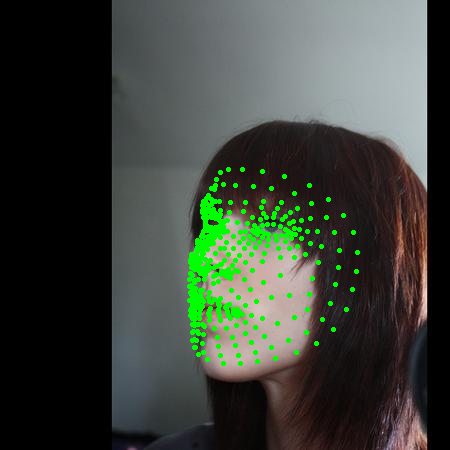

In [20]:
# choosing random image from the testing data
image_name = random.choice(detected_files)
faceModule = mediapipe.solutions.face_mesh
with faceModule.FaceMesh(static_image_mode=True) as face:
  # reading the image
  frame = cv2.imread('/content/AFLW2000/' + image_name + '.jpg')
  # processing the image to detect the face and then generating the land marks (468 for each x,y,z).
  results = face.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
  if results.multi_face_landmarks != None:
    for face in results.multi_face_landmarks:
        # 
        for j,landmark in enumerate(face.landmark):
            x = landmark.x
            y = landmark.y
            shape = frame.shape 
            relative_x = int(x * shape[1])
            relative_y = int(y * shape[0])
            cv2.circle(frame, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
    cv2_imshow(frame)

# Drawing the axis on image 

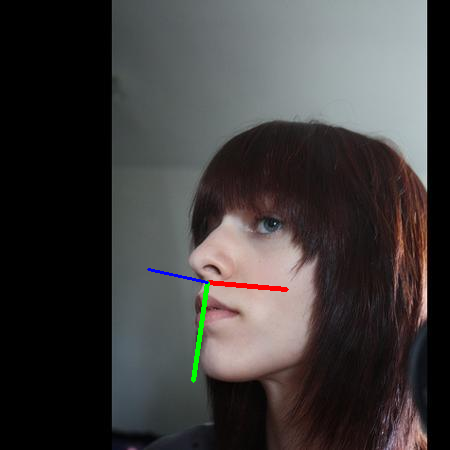

In [21]:
# reading the image
frame = cv2.imread('/content/AFLW2000/' + image_name + '.jpg')
# reading the true labels and drawing the axis on the image
mat = sio.loadmat('/content/AFLW2000/' + image_name + '.mat')
pitch_true = mat["Pose_Para"][0][0]
yaw_true = mat["Pose_Para"][0][1]
roll_true = mat["Pose_Para"][0][2]
cv2_imshow(draw_axis(frame,pitch_true,yaw_true,roll_true,X[98],Y[98]))

# Loading  video

In [22]:
%%capture
!git clone https://github.com/habibakohla/machine-learning-project

# Testing  video

In [ ]:
cap = cv2.VideoCapture('/content/machine-learning-project/WhatsApp Video 2022-06-17 at 1.45.31 AM.mp4')
w= int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h= int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

if (cap.isOpened()== False): 
    print("Error opening video file")
 
img_array = []
# Read video
while(cap.isOpened()):   
    ret, frame = cap.read()
    if ret == True:
      with faceModule.FaceMesh(static_image_mode=True) as face:
        # processing the image to detect the face and then generating the land marks (468 for each x,y,z).
        results = face.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks != None:
          for face in results.multi_face_landmarks:
              X = []
              Y = []
              for j,landmark in enumerate(face.landmark):
                  x = landmark.x
                  y = landmark.y
                  # retrieve the true values of x and y
                  shape = frame.shape 
                  relative_x = int(x * shape[1])
                  relative_y = int(y * shape[0])
                  X.append(relative_x)
                  Y.append(relative_y)

              X = np.array(X)
              Y = np.array(Y)
              # centering the data 
              X_c = X - X[98]
              Y_c = Y - Y[98]
              d = np.linalg.norm(np.array((X[171],Y[171])) - np.array((X[10],Y[10])))
              X_norm = X_c/d
              Y_norm = Y_c/d
              points = np.hstack([X_norm,Y_norm]).reshape(1,-1)
              # predicting the 3 angels 
              pred_pitch = svr_best_pitch.predict(points)
              pred_yaw = svr_best_yaw.predict(points)
              pred_roll = svr_best_roll.predict(points)
              
            
              draw_axis(frame,pred_pitch,pred_yaw,pred_roll,X[98],Y[98])
              # appending the result frame to the img_array list
              img_array.append(frame)
    # Break the loop
    else: 
        break
cap.release()  

cv2.destroyAllWindows() # Closes all the frames
print("Number of Detected Frames = ",len(img_array))
# converting frames 
vd = cv2.VideoWriter('out.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 20, (w,h))
for i in range(len(img_array)):
  vd.write(img_array[i])
vd.release()


Number of Detected Frames =  134


In [ ]:
from google.colab import files
files.download('/content/out.mp4') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>